# Step 12: Update Model

## Objective

In this step we try to solve the issue of data drift by testing several different hypothesis to update the model.

We tested the following scenarios:
- Include all avaialable data (original dataset + 1st round of requests)
- Include only new data (1st round of requests)
- Include only recent data (records from 2021 and 2022)
- Include only recent data and only stations in the new data (1st round of requests)

## Findings

The option of including only data from 2021 to 2022 seemed to be the best one since it provided the highest recall - 0.836 in the test set compared to 0.821 in the previous model. The average precision difference also dropped from 0.113 to 0.1.

In [1]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer, Group_Age_Range, Group_Ethnicity

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Hypothesis 1: Include All Data

# Get the data

In [2]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

# statios that have low number of outcomes
drop_stations = ['humberside', 'lancashire', 'metropolitan', 'west-midlands', 'leicestershire']

df_clean = aux_functions.clean_data(df_, drop_cols, drop_stations)
df_clean["is_new"] = False

df_new = pd.read_csv("data/requests1_final.csv")

df_new_clean = aux_functions.clean_new_data(df_new)
df_new_clean["is_new"] = True

df_combined = pd.concat([df_clean,df_new_clean], axis=0)

display(df_combined['is_new'].isna().sum())

df_train, df_test = train_test_split(df_combined, test_size=0.3, random_state=42, stratify=df_combined['is_new'])


0

# Pipeline Definition

In [3]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler()),
            ('extra_imputer', SimpleImputer(strategy='mean')),    # in case station was not present in training set
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)
        ],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [4]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

# columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,0.0,0.869565,0.333333,0.544774,0.552601,0.0,0.515888,0.659974
1,0.666667,0.826087,0.333333,0.484566,0.552601,0.0,0.22537,0.815708
2,0.333333,1.0,0.0,0.544774,0.552601,0.0,0.116657,0.852219
3,0.333333,0.043478,1.0,0.484566,0.31219,0.0,0.125983,0.711069
4,0.666667,0.73913,0.5,0.484566,0.552601,0.0,0.510872,0.653286
...,...,...,...,...,...,...,...,...
99345,1.0,0.913043,0.666667,0.544774,0.552601,0.0,0.621013,0.691511
99346,1.0,0.347826,1.0,0.484566,0.552601,0.0,0.25605,0.595618
99347,0.333333,1.0,0.666667,0.544774,0.552601,0.0,0.141644,0.830977
99348,0.0,0.478261,1.0,0.484566,0.552601,0.0,0.208473,0.560933


# Predict

In [5]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

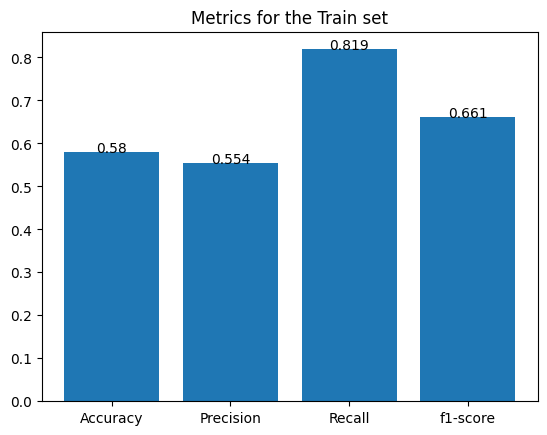

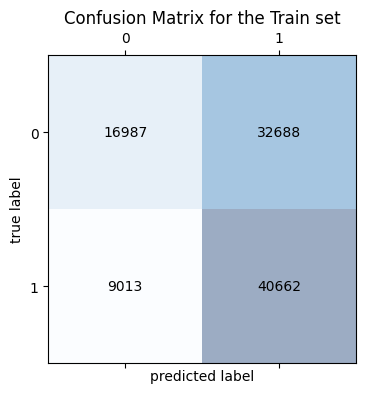

In [6]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

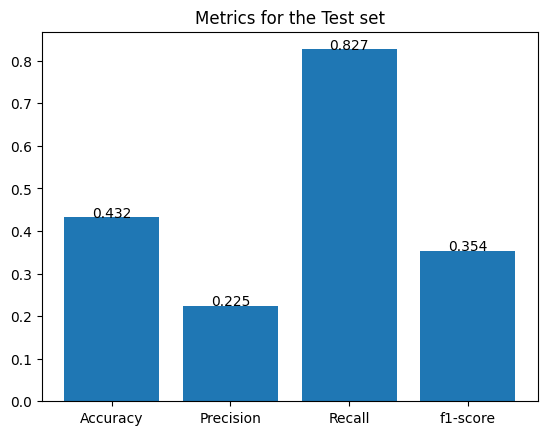

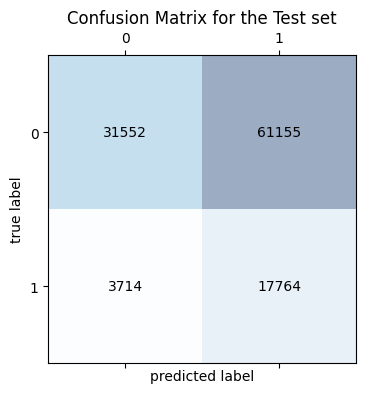

In [7]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

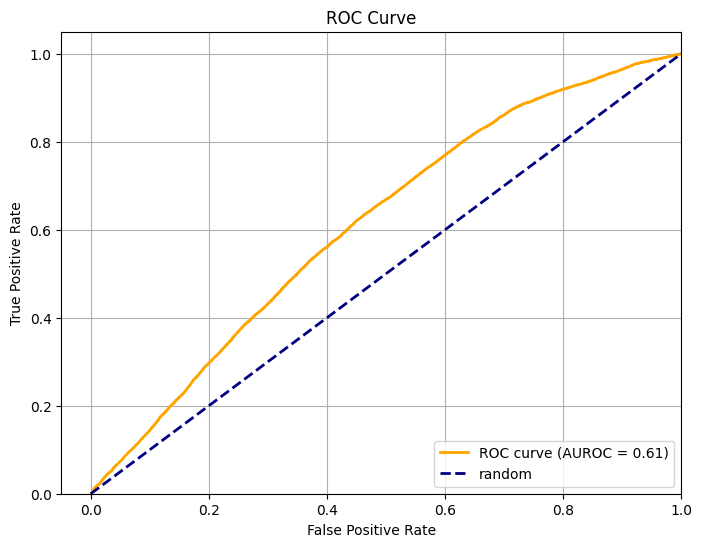

In [8]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (True, 0.8270788714032964)


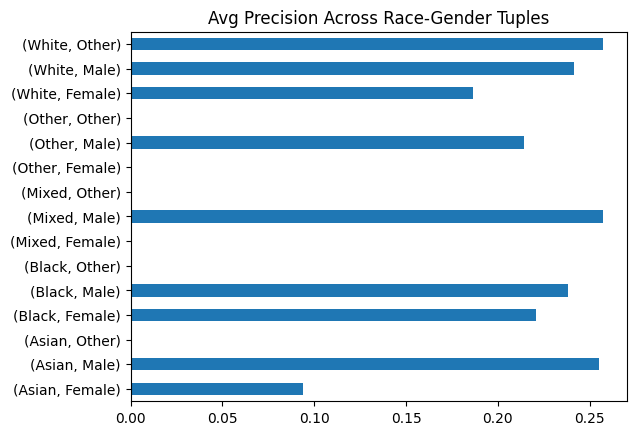

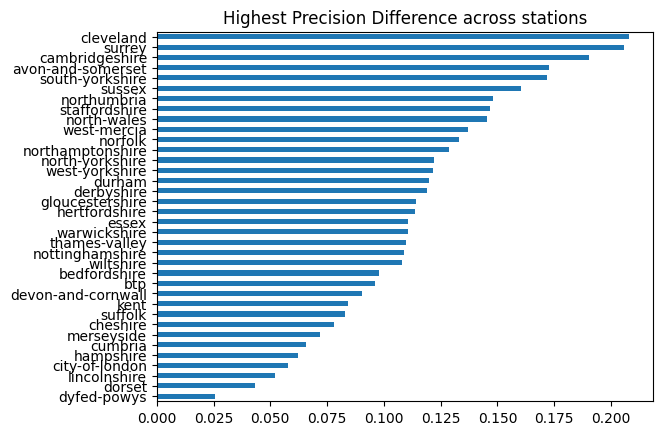

Discrimination requirement
Requirement failed
Global rates: {('Black', 'Male'): 0.23821260152871085, ('Black', 'Female'): 0.2205409682480116, ('Black', 'Other'): nan, ('White', 'Male'): 0.24142467955572597, ('White', 'Female'): 0.1863150896828714, ('White', 'Other'): 0.257364953886693, ('Asian', 'Male'): 0.2553778862733315, ('Asian', 'Female'): 0.09413067552602435, ('Asian', 'Other'): nan, ('Other', 'Male'): 0.2145092307165156, ('Other', 'Female'): nan, ('Other', 'Other'): nan, ('Mixed', 'Male'): 0.2573545666453997, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan}
Num problematic departments: 34
Num good departments: 2
avg diff: 0.114305


In [9]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

# Hypothesis 2: Include Only New Data

# Get the data

In [10]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

# statios that have low number of outcomes
drop_stations = ['humberside', 'lancashire', 'metropolitan', 'west-midlands', 'leicestershire']

df_clean = aux_functions.clean_data(df_, drop_cols, drop_stations)
df_clean["is_new"] = False

df_new = pd.read_csv("data/requests1_final.csv")

df_new_clean = aux_functions.clean_new_data(df_new)
df_new_clean["is_new"] = True

df_combined = pd.concat([df_clean,df_new_clean], axis=0)

df_final = df_combined[df_combined['is_new']]

df_train, df_test = train_test_split(df_final, test_size=0.3, random_state=42)


# Pipeline Definition

In [11]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler()),
            ('extra_imputer', SimpleImputer(strategy='mean')),    # in case station was not present in training set
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)
        ],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [12]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

# columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,0.0,0.0,0.666667,0.471459,0.328672,0.0,0.983141,0.73516
1,0.0,0.956522,1.0,0.471459,0.536446,0.0,0.508462,0.889014
2,0.0,0.521739,0.166667,0.471459,0.536446,0.0,0.092759,0.319515
3,0.0,0.652174,0.666667,0.471459,0.328672,0.0,0.112521,0.407571
4,0.0,0.782609,0.666667,0.604651,0.536446,0.0,0.436047,0.894868
...,...,...,...,...,...,...,...,...
1199,0.0,0.869565,0.666667,0.471459,0.328672,0.0,0.929865,0.69838
1200,0.0,1.0,0.833333,0.604651,0.536446,0.0,0.16429,0.380055
1201,0.0,0.869565,0.333333,0.471459,0.536446,0.0,0.232558,0.327797
1202,0.0,0.782609,1.0,0.471459,0.536446,0.0,0.438518,0.892617


# Predict

In [13]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

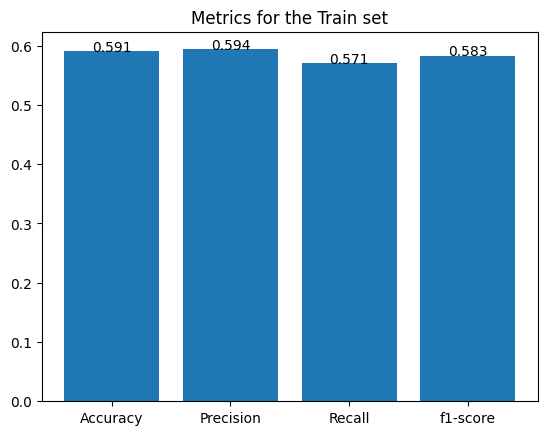

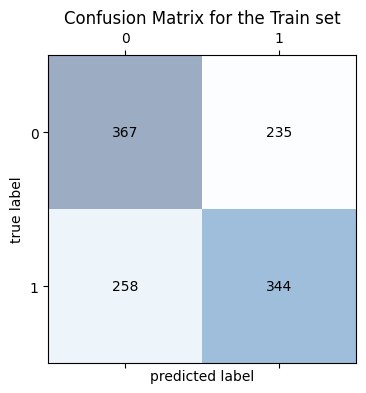

In [14]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

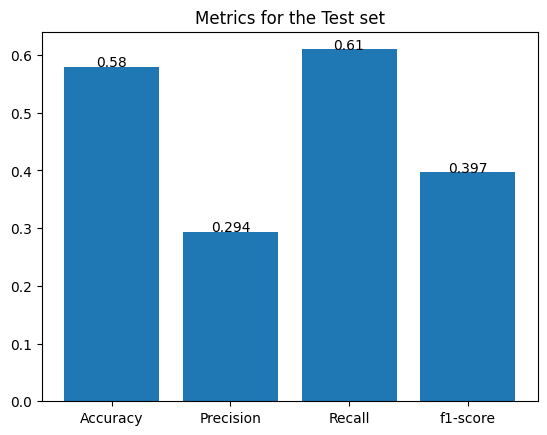

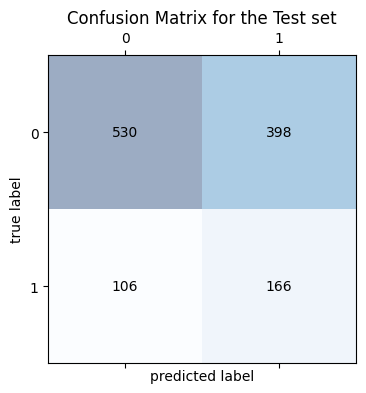

In [15]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

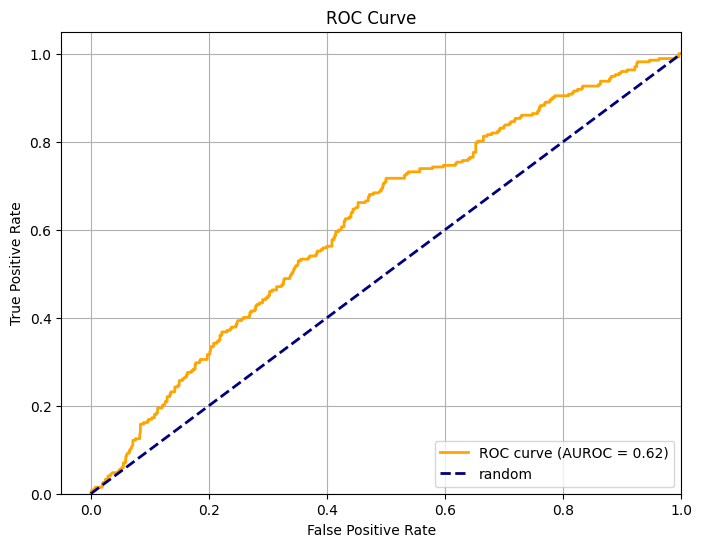

In [16]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (False, 0.6102941176470589)


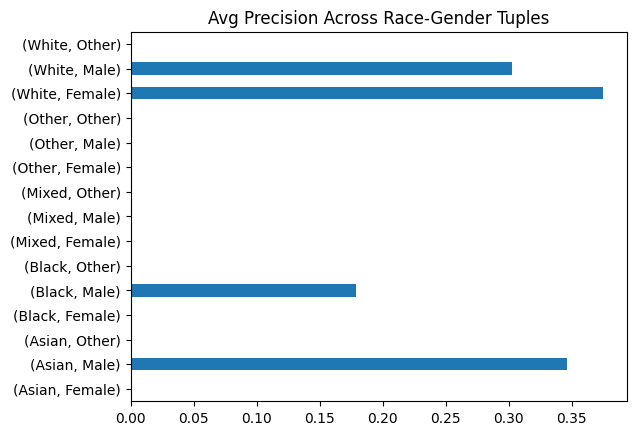

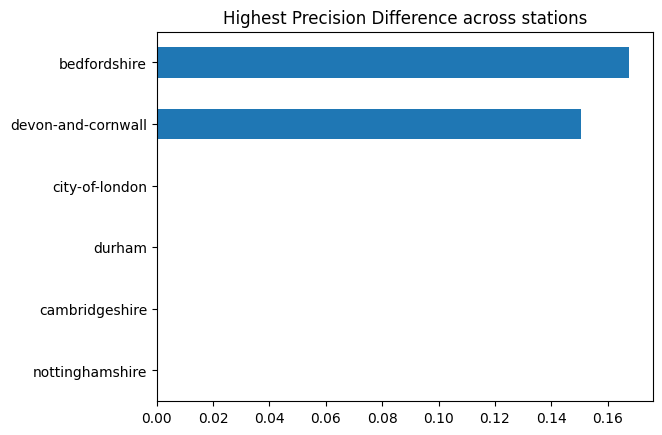

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.30254759892721944, ('White', 'Female'): 0.375, ('White', 'Other'): nan, ('Mixed', 'Male'): nan, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Black', 'Male'): 0.17857142857142858, ('Black', 'Female'): nan, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.34615384615384615, ('Asian', 'Female'): nan, ('Asian', 'Other'): nan, ('Other', 'Male'): nan, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 2
Num good departments: 4
avg diff: 0.053015


In [17]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

# Hypothesis 3: Include Recent Data

# Get the data

In [18]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

# statios that have low number of outcomes
drop_stations = ['humberside', 'lancashire', 'metropolitan', 'west-midlands', 'leicestershire']

df_clean = aux_functions.clean_data(df_, drop_cols, drop_stations)
df_clean["is_new"] = False

df_new = pd.read_csv("data/requests1_final.csv")

df_new_clean = aux_functions.clean_new_data(df_new)
df_new_clean["is_new"] = True

df_combined = pd.concat([df_clean,df_new_clean], axis=0)

df_combined["year"] = pd.to_datetime(df_combined["Date"], infer_datetime_format=True, dayfirst=False).dt.year

df_final = df_combined[df_combined["year"] >= 2021]

display(df_final["year"].value_counts())

df_train, df_test = train_test_split(df_final.drop(columns=["year"]), test_size=0.3, random_state=42)


2021    185059
2022      4000
Name: year, dtype: int64

# Pipeline Definition

In [19]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler()),
            ('extra_imputer', SimpleImputer(strategy='mean')),    # in case station was not present in training set
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)
        ],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [20]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

# columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,1.0,0.782609,0.666667,0.488212,0.552382,0.0,0.515787,0.519093
1,1.0,0.26087,0.666667,0.488212,0.552382,0.0,0.490178,0.51933
2,0.666667,0.73913,1.0,0.488212,0.506325,0.0,0.538316,0.664155
3,0.666667,0.347826,0.833333,0.488212,0.304678,0.0,0.223698,0.81245
4,0.333333,0.956522,0.666667,0.488212,0.552382,0.0,0.534688,0.653133
...,...,...,...,...,...,...,...,...
48155,0.0,1.0,0.0,0.488212,0.552382,0.0,0.484817,0.51823
48156,1.0,0.826087,0.5,0.537253,0.552382,1.0,0.433096,0.671368
48157,0.666667,0.652174,0.0,0.488212,0.552382,0.0,0.491603,0.51609
48158,0.666667,0.0,0.833333,0.488212,0.552382,0.0,0.271676,0.593182


# Predict

In [21]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

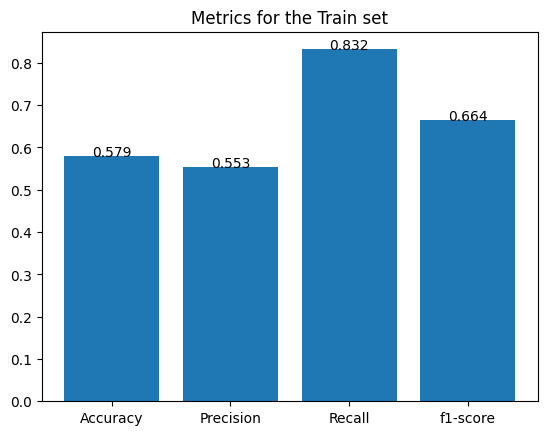

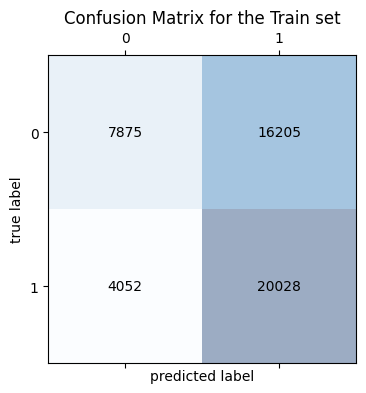

In [22]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

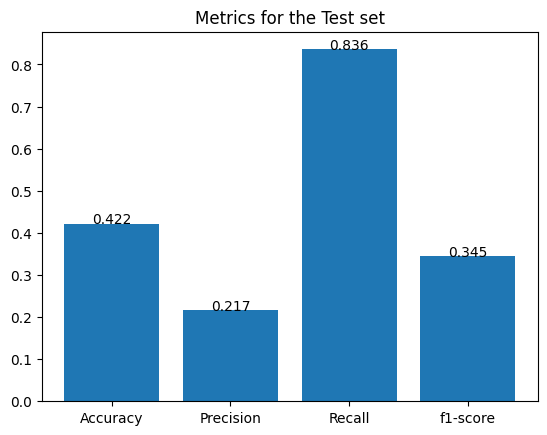

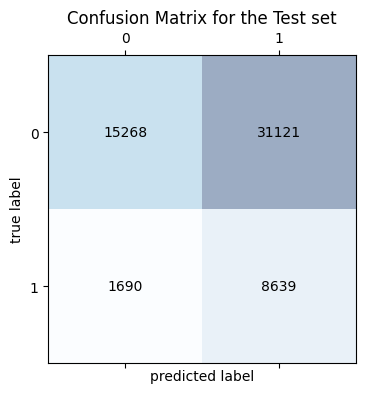

In [23]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

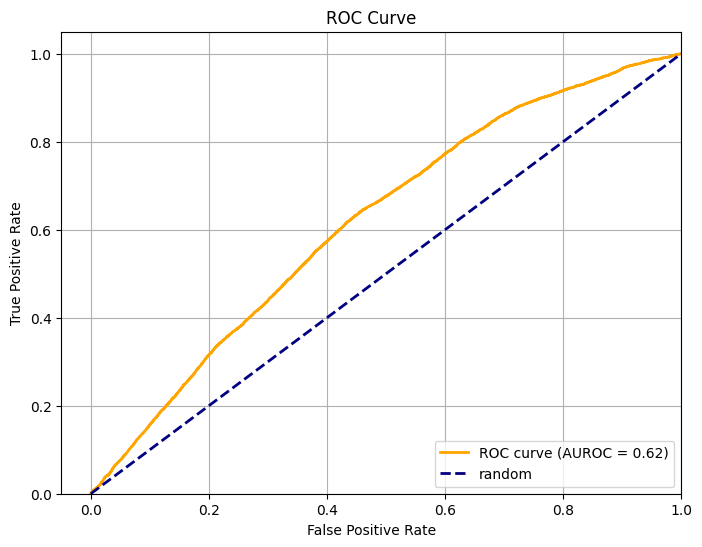

In [24]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (True, 0.8363829993222964)


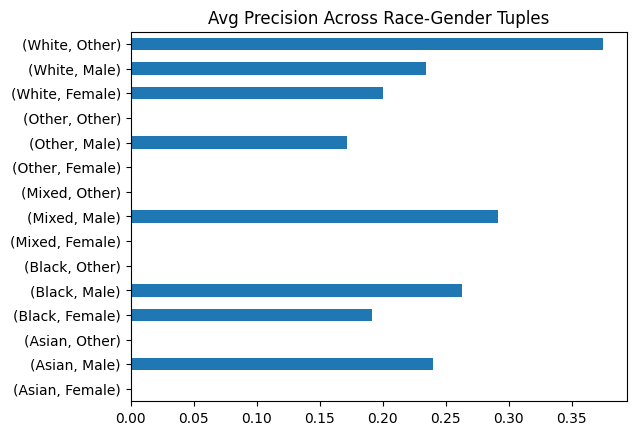

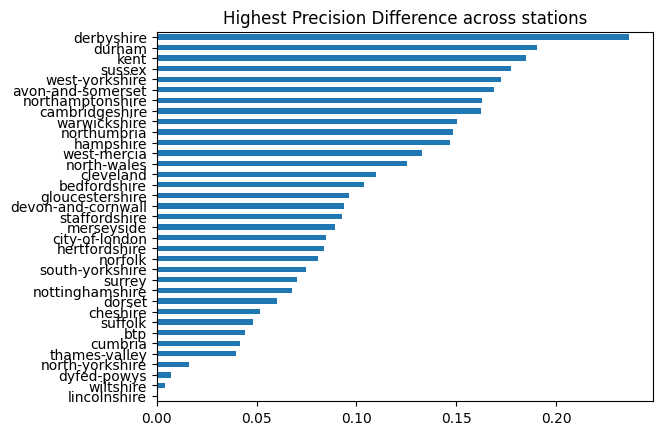

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.23463575083412377, ('White', 'Female'): 0.20003964174361494, ('White', 'Other'): 0.375, ('Black', 'Male'): 0.26321269270724346, ('Black', 'Female'): 0.19175627240143367, ('Black', 'Other'): nan, ('Other', 'Male'): 0.17167536575968573, ('Other', 'Female'): nan, ('Other', 'Other'): nan, ('Asian', 'Male'): 0.23989373986085508, ('Asian', 'Female'): nan, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.2914473684210526, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan}
Num problematic departments: 27
Num good departments: 8
avg diff: 0.10054685714285715


In [25]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

# Hypothesis 4: Include only recent data and stations in new data

# Get the data

In [26]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

# statios that have low number of outcomes
drop_stations = ['humberside', 'lancashire', 'metropolitan', 'west-midlands', 'leicestershire']

df_clean = aux_functions.clean_data(df_, drop_cols, drop_stations)
df_clean["is_new"] = False

df_new = pd.read_csv("data/requests1_final.csv")

df_new_clean = aux_functions.clean_new_data(df_new)
df_new_clean["is_new"] = True

stations_in_new_data = list(df_new_clean["station"].unique())

df_combined = pd.concat([df_clean,df_new_clean], axis=0)

df_combined["year"] = pd.to_datetime(df_combined["Date"], infer_datetime_format=True, dayfirst=False).dt.year

df_final = df_combined.loc[(df_combined["year"] >= 2021) & (df_combined["station"].isin(stations_in_new_data)),:]

display(list(df_final["station"].unique()))
display(df_final["year"].value_counts())

df_train, df_test = train_test_split(df_final.drop(columns=["year"]), test_size=0.3, random_state=42)


['durham',
 'cambridgeshire',
 'bedfordshire',
 'devon-and-cornwall',
 'nottinghamshire',
 'city-of-london']

2021    18010
2022     4000
Name: year, dtype: int64

# Pipeline Definition

In [27]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler()),
            ('extra_imputer', SimpleImputer(strategy='mean')),    # in case station was not present in training set
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)
        ],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [28]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

# columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,0.826087,0.666667,0.589005,0.54864,0.0,0.507573,0.795254
1,0.0,0.565217,0.666667,0.589005,0.346789,0.0,0.975743,0.629495
2,0.0,0.869565,1.0,0.475487,0.290909,0.0,0.387342,0.611808
3,0.0,0.26087,0.333333,0.475487,0.54864,0.0,0.320539,0.818124
4,1.0,1.0,0.833333,0.475487,0.346789,1.0,0.387342,0.611808
...,...,...,...,...,...,...,...,...
7071,0.0,0.826087,0.0,0.475487,0.54864,0.0,0.414666,0.777072
7072,1.0,1.0,0.666667,0.475487,0.54864,0.0,0.925235,0.627913
7073,0.333333,0.565217,0.166667,0.475487,0.54864,0.0,0.122602,0.302442
7074,0.666667,0.869565,0.666667,0.475487,0.54864,0.0,0.397084,0.773459


# Predict

In [29]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

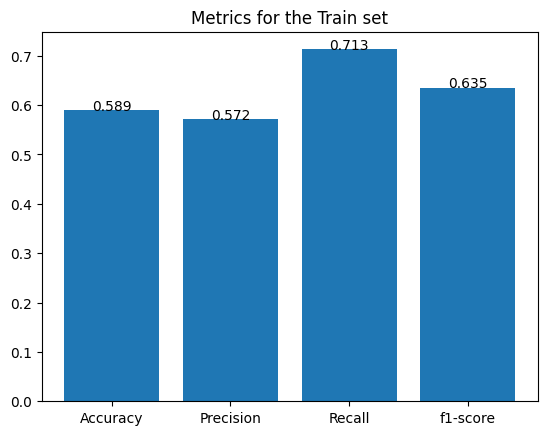

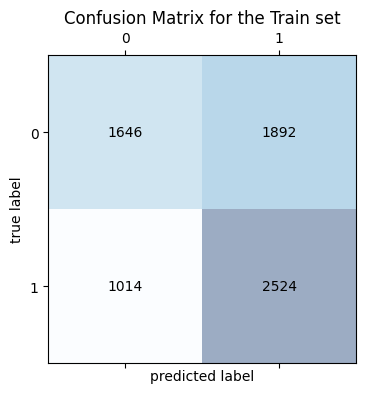

In [30]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

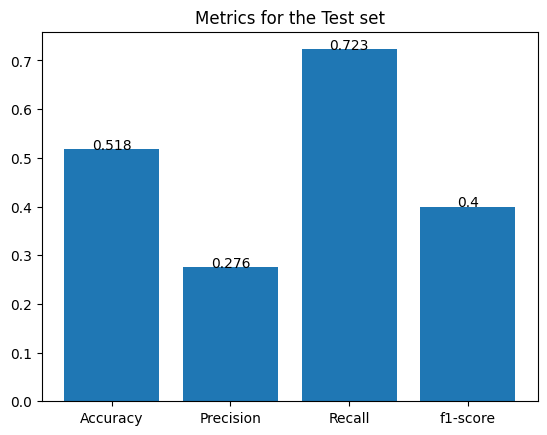

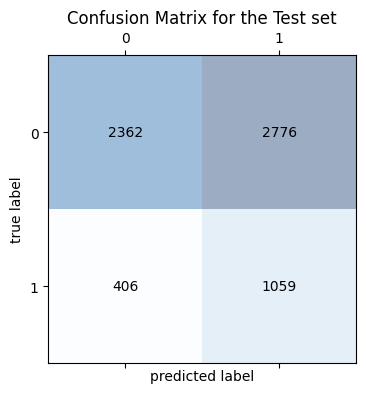

In [31]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

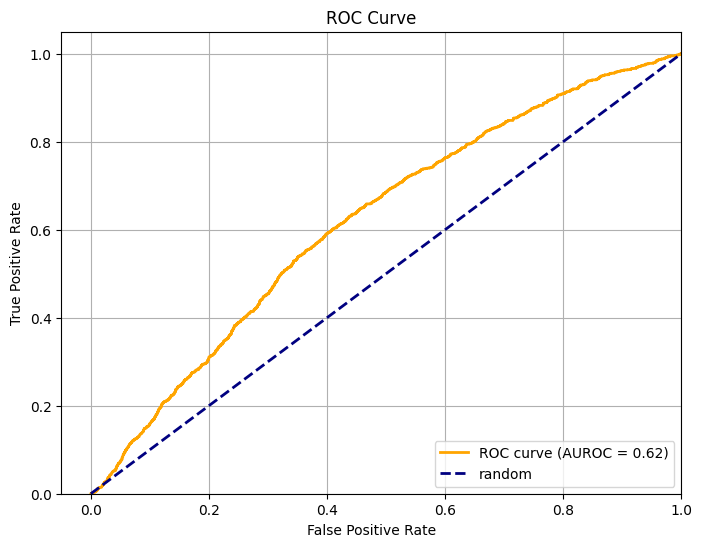

In [32]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (False, 0.7228668941979522)


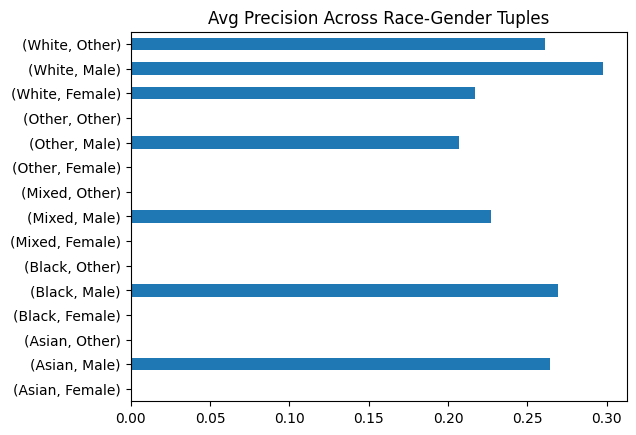

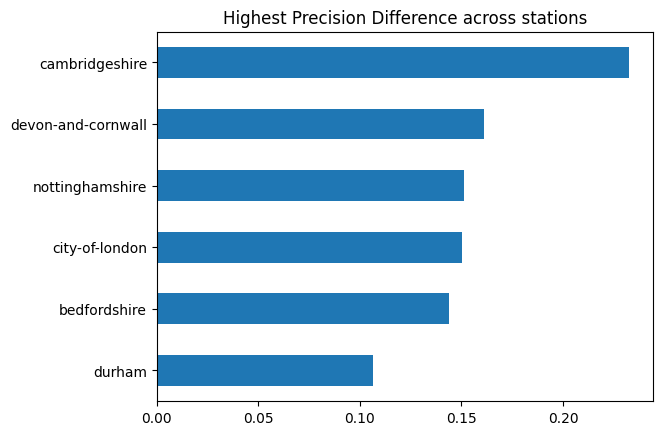

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.2977153610158059, ('White', 'Female'): 0.21685644475766228, ('White', 'Other'): 0.2608695652173913, ('Black', 'Male'): 0.26897525253295507, ('Black', 'Female'): nan, ('Black', 'Other'): nan, ('Other', 'Male'): 0.20689655172413793, ('Other', 'Female'): nan, ('Other', 'Other'): nan, ('Mixed', 'Male'): 0.22727272727272727, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Asian', 'Male'): 0.2644099145692066, ('Asian', 'Female'): nan, ('Asian', 'Other'): nan}
Num problematic departments: 6
Num good departments: 0
avg diff: 0.15750666666666666


In [33]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")